In [27]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

image_path = "C:/Users/USER/OneDrive/桌面/Beauty Filter/Beauty Filter Style/train/input/001001.jpg" # image path
image = Image.open(image_path).convert("RGB")

width, height = image.size # image size and mode
mode = image.mode

print(f'圖片尺寸: 寬度 {width} 像素, 高度 {height} 像素')
print(f'圖片模式: {mode}')

transform = transforms.Compose([
    transforms.Resize((224, 192)),
    transforms.ToTensor()
])

transformed_image = transform(image)

print(f'轉換後的 Tensor尺寸: {transformed_image.shape}')
print(f'數據類型: {transformed_image.dtype}')

圖片尺寸: 寬度 178 像素, 高度 218 像素
圖片模式: RGB
轉換後的 Tensor尺寸: torch.Size([3, 224, 192])
數據類型: torch.float32


In [28]:
class CustomImageDataset(Dataset):
    def __init__(self, img_in_dir, img_label_dir, transform=None):
        self.img_in_dir = img_in_dir
        self.img_label_dir = img_label_dir
        self.transform = transform
        self.images = os.listdir(img_in_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_in_path = os.path.join(self.img_in_dir, self.images[idx])
        img_label_path = os.path.join(self.img_label_dir, self.images[idx])
        
        image_in = Image.open(img_in_path).convert("RGB")
        image_label = Image.open(img_label_path).convert("RGB")
        
        if self.transform:
            image_in = self.transform(image_in)
            image_label = self.transform(image_label)
        
        return image_in, image_label

img_input = "C:/Users/USER/OneDrive/桌面/Beauty Filter/Beauty Filter Style/train/input"
img_label = "C:/Users/USER/OneDrive/桌面/Beauty Filter/Beauty Filter Style/train/label"

trainset = CustomImageDataset(img_in_dir=img_input, img_label_dir=img_label, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)

In [29]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.middle = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        mid = self.middle(self.pool3(enc3))
        dec3 = self.decoder3(torch.cat([self.upconv3(mid), enc3], dim=1))
        dec2 = self.decoder2(torch.cat([self.upconv2(dec3), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        return dec1

model = UNet()

Epoch [1/50], Loss: 0.0135426
Epoch [2/50], Loss: 0.0011669
Epoch [3/50], Loss: 0.0008456
Epoch [4/50], Loss: 0.0004324
Epoch [5/50], Loss: 0.0002286
Epoch [6/50], Loss: 0.0001956
Epoch [7/50], Loss: 0.0001532
Epoch [8/50], Loss: 0.0001405
Epoch [9/50], Loss: 0.0001477
Epoch [10/50], Loss: 0.0001184
Epoch [11/50], Loss: 0.0001240
Epoch [12/50], Loss: 0.0002117
Epoch [13/50], Loss: 0.0000869
Epoch [14/50], Loss: 0.0001106
Epoch [15/50], Loss: 0.0000819
Epoch [16/50], Loss: 0.0001144
Epoch [17/50], Loss: 0.0000920
Epoch [18/50], Loss: 0.0001460
Epoch [19/50], Loss: 0.0000993
Epoch [20/50], Loss: 0.0000765
Epoch [21/50], Loss: 0.0000641
Epoch [22/50], Loss: 0.0000702
Epoch [23/50], Loss: 0.0001002
Epoch [24/50], Loss: 0.0001141
Epoch [25/50], Loss: 0.0000966
Epoch [26/50], Loss: 0.0001126
Epoch [27/50], Loss: 0.0000703
Epoch [28/50], Loss: 0.0000714
Epoch [29/50], Loss: 0.0000892
Epoch [30/50], Loss: 0.0000768
Epoch [31/50], Loss: 0.0000835
Epoch [32/50], Loss: 0.0001042
Epoch [33/50], Lo

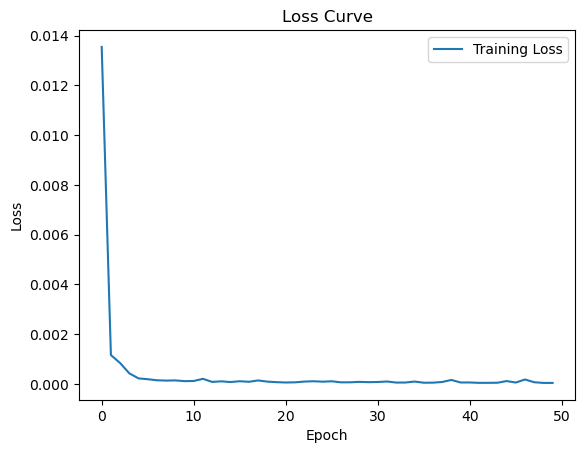

In [30]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=0)

torch.cuda.empty_cache()
num_epochs = 50
loss_history = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(trainloader)
    loss_history.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.7f}')

print('Finished Training')
print("Here is the loss curve")

plt.figure()
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [31]:
# Save the trained model
torch.save(model.state_dict(), 'beauty_unet_model.pth')

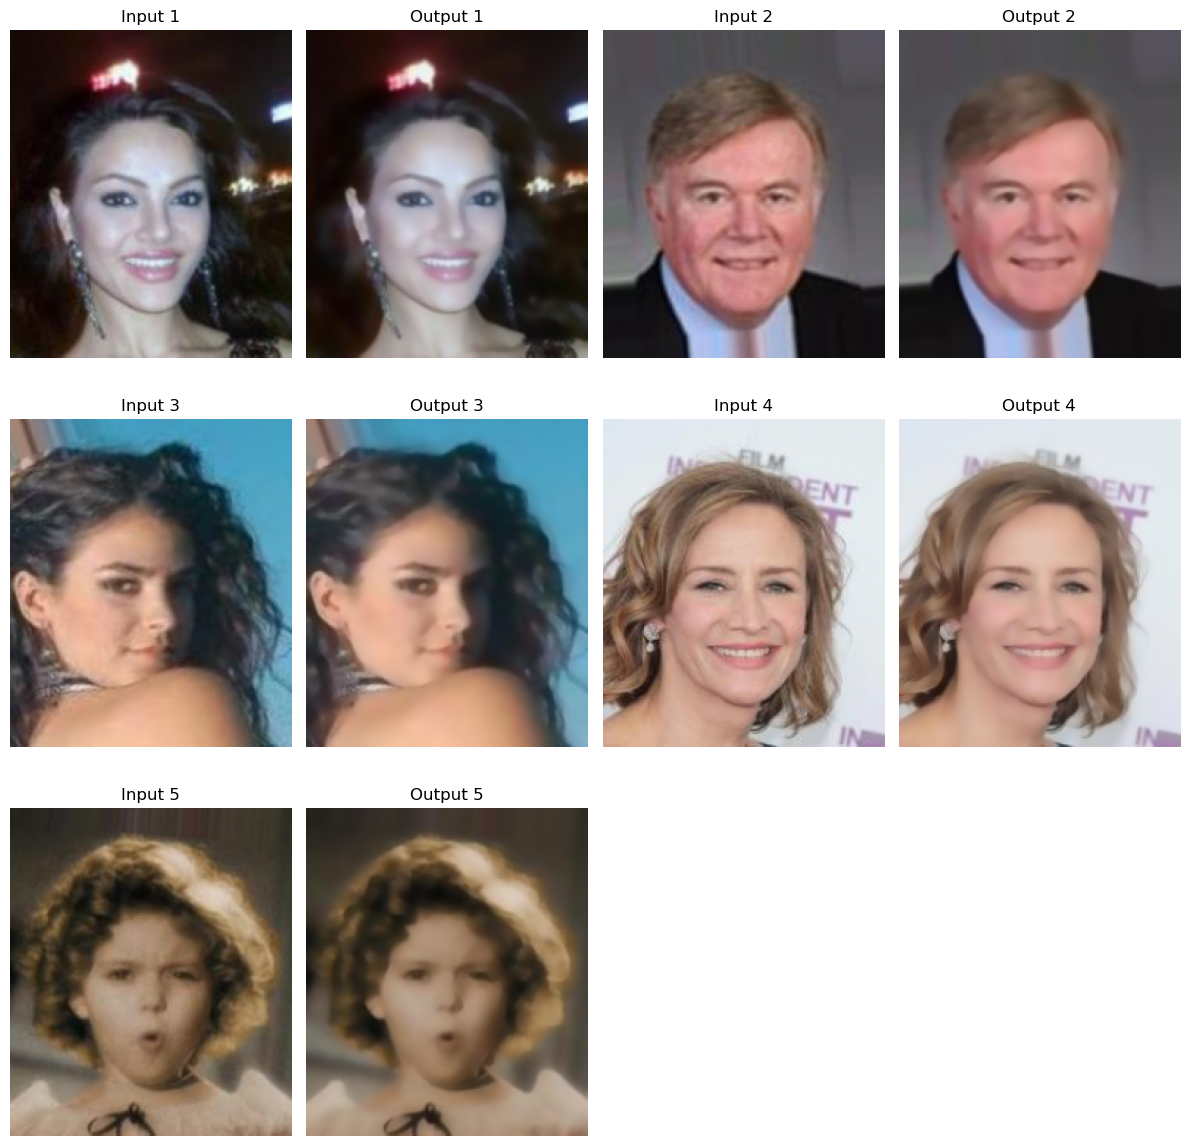

done


In [32]:
# test whether the model works

model = UNet() # define UNet 

model.load_state_dict(torch.load("beauty_unet_model.pth", map_location="cpu"))# load in the trained model
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 192)),
    transforms.ToTensor()
])

test_image1 = Image.open("beauty filter test/002496.jpg").convert("RGB")
input_tensor1 = transform(test_image1).unsqueeze(0)

test_image2 = Image.open("beauty filter test/002497.jpg").convert("RGB")
input_tensor2 = transform(test_image2).unsqueeze(0)

test_image3 = Image.open("beauty filter test/002498.jpg").convert("RGB")
input_tensor3 = transform(test_image3).unsqueeze(0)

test_image4 = Image.open("beauty filter test/002499.jpg").convert("RGB")
input_tensor4 = transform(test_image4).unsqueeze(0)

test_image5 = Image.open("beauty filter test/002500.jpg").convert("RGB")
input_tensor5 = transform(test_image5).unsqueeze(0)

with torch.no_grad():
    output_tensor1 = model(input_tensor1)[0] 
with torch.no_grad():
    output_tensor2 = model(input_tensor2)[0]
with torch.no_grad():
    output_tensor3 = model(input_tensor3)[0]
with torch.no_grad():   
    output_tensor4 = model(input_tensor4)[0]
with torch.no_grad():
    output_tensor5 = model(input_tensor5)[0]    

inputs = [input_tensor1, input_tensor2, input_tensor3, input_tensor4, input_tensor5]
outputs = [output_tensor1, output_tensor2, output_tensor3, output_tensor4, output_tensor5]

num_pairs = len(inputs)
cols = 2  # 每列兩組
rows = (num_pairs + cols - 1) // cols  

plt.figure(figsize=(12, 4 * rows))
for i in range(num_pairs):
    row = i // cols
    col = i % cols
    # Input
    plt.subplot(rows, cols * 2, row * cols * 2 + col * 2 + 1)
    plt.imshow(inputs[i][0].permute(1, 2, 0).cpu().numpy())
    plt.title(f"Input {i+1}")
    plt.axis('off')
    # Output
    plt.subplot(rows, cols * 2, row * cols * 2 + col * 2 + 2)
    plt.imshow(outputs[i].permute(1, 2, 0).detach().cpu().numpy())
    plt.title(f"Output {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("done")